<font size="6"> **Model Building: Random Forest** </font>

In [1]:
%%capture
%run 00_mlmod_load_data.ipynb

In [2]:
KFOLDS = 3
print('Model version: ', MODEL_VERSION)

Model version:  v01


In [3]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Overwrite persisted versions of sampled data
X_train_smp = pd.read_csv(io_utils.interim_path + 'x_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = pd.read_csv(io_utils.interim_path + 'y_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = y_train_smp[target_col]

In [5]:
(y_train_smp>0).value_counts()

True     24038
False    18957
Name: target, dtype: int64

# Decision Tree

In [6]:
select_sum_cols = ['mean_test_w_accuracy', 'std_test_w_accuracy', 'rank_test_w_accuracy',
                   'mean_test_accuracy', 'mean_test_up_accuracy','mean_test_down_accuracy', 'mean_test_neg_root_mean_squared_error']

## Hyperparamenter Tunning

In [7]:
hpgrid_dtr = {'ccp_alpha': [0., 1e-6, 1e-5, 1e-4]}

In [8]:
dtr_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)
dtr = DecisionTreeRegressor(criterion='mse', min_samples_leaf=500, random_state=RND_SEED)

In [9]:
dtr_cv = GridSearchCV(dtr, hpgrid_dtr, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=dtr_tscv_smp, return_train_score=True)
res_dtr_cv = dtr_cv.fit(X_train_smp, y_train_smp)

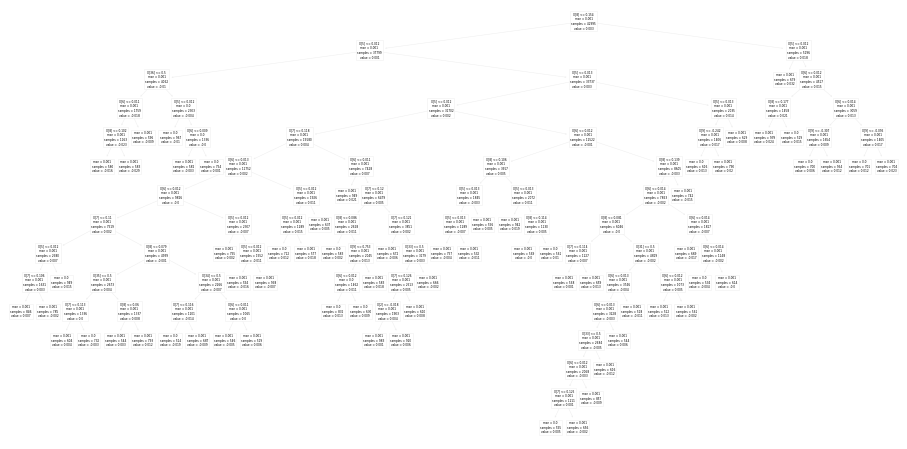

In [46]:
from sklearn import tree

tree.plot_tree(res_dtr_cv.best_estimator_);


In [54]:
n_nodes = res_dtr_cv.best_estimator_.tree_.node_count
children_left = res_dtr_cv.best_estimator_.tree_.children_left
children_right = res_dtr_cv.best_estimator_.tree_.children_right
feature = res_dtr_cv.best_estimator_.tree_.feature
threshold = res_dtr_cv.best_estimator_.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
tree_depth = 0
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1
    tree_depth = max(tree_depth, node_depth[node_id])

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True
        
print(f'Tree depth: {tree_depth}')

Tree depth: 14


## CV Grid Search Analysis

In [10]:
dtr_params_df = pd.DataFrame(res_dtr_cv.cv_results_['params'])
dtr_metrics_df = pd.DataFrame(res_dtr_cv.cv_results_)[select_sum_cols]
dtr_sum_df = dtr_params_df.join(dtr_metrics_df)
dtr_sum_df.sort_values(by='rank_test_w_accuracy').head(20)

,ccp_alpha,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
0,0.000000,0.437234,0.037664,1,0.517026,0.464346,0.571060,-0.031122
1,0.000001,0.430762,0.036272,2,0.523415,0.536328,0.500359,-0.031088
2,0.000010,0.414990,0.045244,3,0.512685,0.575352,0.443823,-0.029477
3,0.000100,0.383269,0.019324,4,0.553870,1.000000,0.000000,-0.028261


# Basic Random Forest: Number of Trees estimation

## Hyperparamenter Tunning

In [11]:
brf_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)
brf = RandomForestRegressor(criterion='mse',
                           max_samples= 0.75, max_features='auto', min_samples_leaf=500,
                            bootstrap=True, oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)

In [12]:
hpgrid_brf = {'n_estimators': [100, 200, 500, 1000]}

In [13]:
brf_cv = GridSearchCV(brf, hpgrid_brf, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=brf_tscv_smp, return_train_score=True)
res_brf_cv = brf_cv.fit(X_train_smp, y_train_smp)

## CV Grid Search Analysis

In [14]:
brf_params_df = pd.DataFrame(res_brf_cv.cv_results_['params'])
brf_metrics_df = pd.DataFrame(res_brf_cv.cv_results_)[select_sum_cols]
brf_sum_df = dtr_params_df.join(brf_metrics_df)
brf_sum_df.sort_values(by='rank_test_w_accuracy')

,ccp_alpha,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
1,0.000001,0.469964,0.014901,1,0.513460,0.292127,0.793478,-0.029021
3,0.000100,0.468616,0.016720,2,0.513708,0.299933,0.784842,-0.029014
2,0.000010,0.468238,0.017234,3,0.513553,0.300794,0.783493,-0.029025
0,0.000000,0.466984,0.018068,4,0.511785,0.295668,0.785314,-0.029013


# Random Forest Weekly Sampling

## Hyperparamenter Tunning

In [15]:
hpgrid_rf_smp = {'max_samples': [0.5, 0.75],
            'max_features': [0.25, 0.5, 0.75],
            'min_samples_leaf': [250, 500, 1000, 2500]}

In [16]:
rf_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)

In [17]:
rf_cv = GridSearchCV(rf, hpgrid_rf_smp, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=rf_tscv_smp, return_train_score=True)
res_rf_cv = rf_cv.fit(X_train_smp, y_train_smp)

## CV Grid Search Analysis

In [18]:
rf_params_df = pd.DataFrame(res_rf_cv.cv_results_['params'])
rf_metrics_df = pd.DataFrame(res_rf_cv.cv_results_)[select_sum_cols]
rf_sum_df = rf_params_df.join(rf_metrics_df)
rf_sum_df.sort_values(by='rank_test_w_accuracy').head(10)

,max_features,max_samples,min_samples_leaf,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
20,0.75,0.75,250,0.462570,0.031751,1,0.534673,0.450645,0.642339,-0.028497
16,0.75,0.50,250,0.461497,0.024945,2,0.525462,0.404242,0.684237,-0.028363
18,0.75,0.50,1000,0.455906,0.030793,3,0.537185,0.496911,0.588303,-0.028225
12,0.50,0.75,250,0.452483,0.044123,4,0.533681,0.504926,0.577100,-0.028276
21,0.75,0.75,500,0.449820,0.040887,5,0.522609,0.449131,0.621235,-0.028339
13,0.50,0.75,500,0.445844,0.034167,6,0.526703,0.489360,0.578189,-0.028121
8,0.50,0.50,250,0.443784,0.039756,7,0.519849,0.465637,0.596334,-0.028222
4,0.25,0.75,250,0.441298,0.023681,8,0.533246,0.540819,0.523041,-0.028110
0,0.25,0.50,250,0.434066,0.025593,9,0.541062,0.623063,0.428040,-0.028056
5,0.25,0.75,500,0.424150,0.026853,10,0.540814,0.674538,0.357398,-0.028024


In [19]:
champ_rf_idx = 17
champ_rf_hparms = res_rf_cv.cv_results_['params'][champ_rf_idx]
champ_rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)
champ_rf.set_params(**champ_rf_hparms)
champ_rf.fit(X_train_smp, y_train_smp)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.75, max_leaf_nodes=None,
                      max_samples=0.5, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=500,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=123, verbose=0, warm_start=False)

In [20]:
select_cvdet_cols = ['split0_test_w_accuracy','split1_test_w_accuracy', 'split2_test_w_accuracy', 'mean_test_w_accuracy', 'std_test_w_accuracy', 'rank_test_w_accuracy',
                    'mean_test_accuracy', 'mean_test_neg_root_mean_squared_error']

In [21]:
rf_metrics_cvdet =  pd.DataFrame(res_rf_cv.cv_results_)[select_cvdet_cols]
rf_metrics_cvdet = rf_metrics_cvdet.join(rf_params_df)
rf_metrics_cvdet.head(2)

,split0_test_w_accuracy,split1_test_w_accuracy,split2_test_w_accuracy,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_neg_root_mean_squared_error,max_features,max_samples,min_samples_leaf
0,0.427054,0.406821,0.468324,0.434066,0.025593,9,0.541062,-0.028056,0.25,0.5,250
1,0.414932,0.400662,0.429929,0.415175,0.011949,17,0.537154,-0.028023,0.25,0.5,500


In [22]:
rf_metrics_cvdet_top = rf_metrics_cvdet.sort_values(by='rank_test_w_accuracy').head(10)
hparams_tb = rf_metrics_cvdet_top.pivot_table(index='rank_test_w_accuracy', values=['max_features', 'max_samples', 'min_samples_leaf']).T

In [23]:
champ_rf_score = rf_metrics_cvdet.loc[champ_rf_idx,'mean_test_w_accuracy']
champ_rf_rank = rf_metrics_cvdet.loc[champ_rf_idx, 'rank_test_w_accuracy']
top_rf_score = rf_metrics_cvdet.loc[rf_metrics_cvdet['rank_test_w_accuracy']==1, 'mean_test_w_accuracy'].iloc[0]
champ_rf_score, champ_rf_rank, top_rf_score

(0.41827869003977974, 14, 0.46257014065938473)

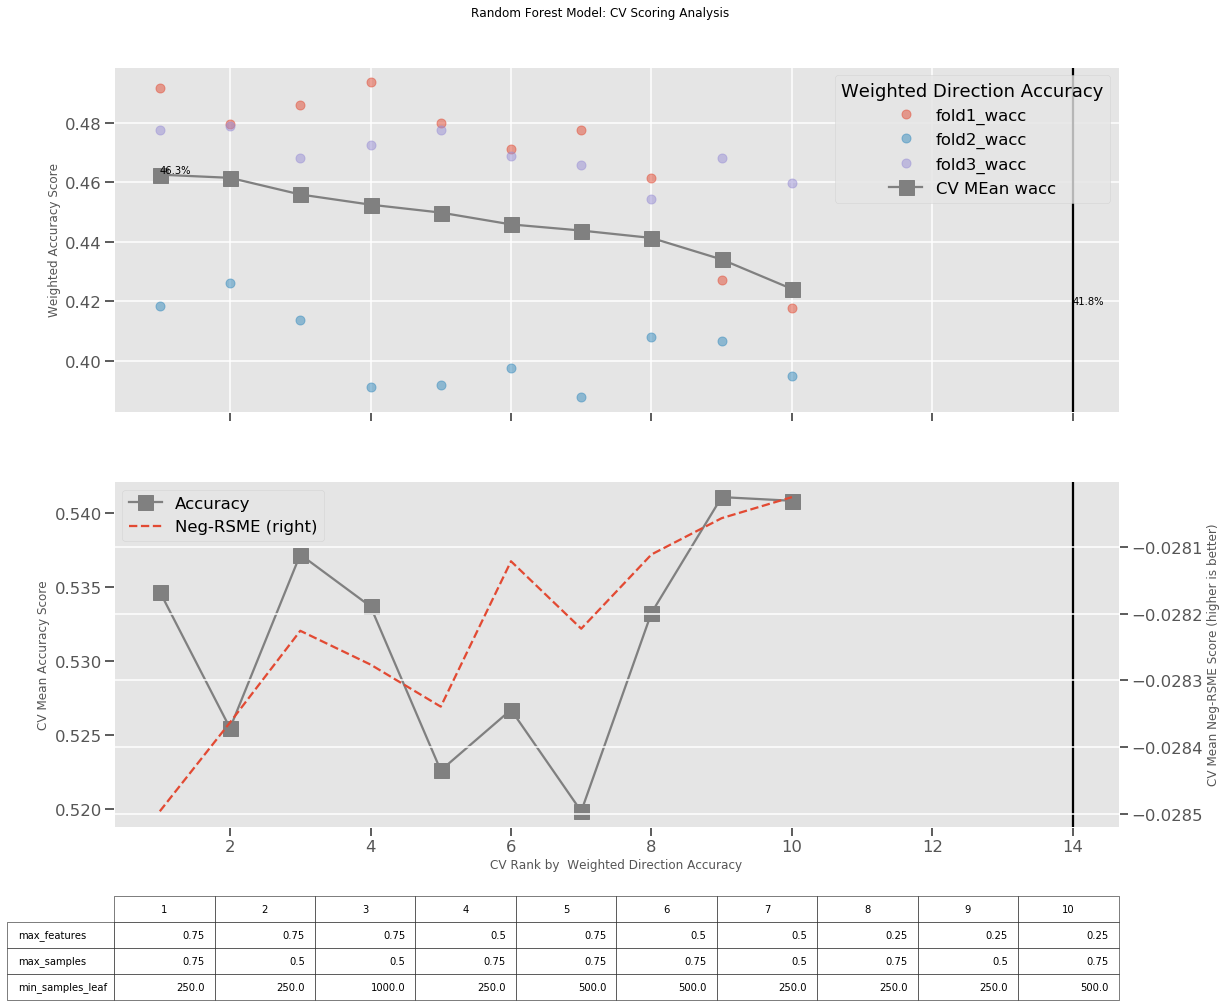

In [24]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(18,12))

plt.suptitle("Random Forest Model: CV Scoring Analysis", y=0.95)
ax = axs[0]
rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y=['split0_test_w_accuracy','split1_test_w_accuracy', 'split2_test_w_accuracy'],
                        style='o', alpha=0.5, label=['fold1_wacc', 'fold2_wacc', 'fold3_wacc'])
rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y='mean_test_w_accuracy',
                        marker='s', markersize=15, color='grey', label='CV MEan wacc')
ax.legend(title="Weighted Direction Accuracy")
ax.set_ylabel('Weighted Accuracy Score')
ax.text(1, top_rf_score, f'{top_rf_score:.1%}', va='bottom', ha='left')
ax.text(champ_rf_rank, champ_rf_score, f'{champ_rf_score:.1%}', va='bottom', ha='left')

ax = axs[1]
rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y='mean_test_accuracy',
                         label='Accuracy',color='grey',
                        marker='s', markersize=15)
plt.ylabel('CV Mean Accuracy Score')

rf_metrics_cvdet_top.plot(ax=ax, x='rank_test_w_accuracy', y='mean_test_neg_root_mean_squared_error',
                         secondary_y=True,
                         label='Neg-RSME',
                         linestyle='--')

plt.ylabel('CV Mean Neg-RSME Score (higher is better)')
ax.set_xlabel('CV Rank by  Weighted Direction Accuracy')

rf_metrics_cvdet_top_tb = ax.table(cellText=hparams_tb.astype(str).values,
                      rowLabels=hparams_tb.index.tolist(),
                      colLabels=hparams_tb.columns.tolist(),
                      loc='bottom',bbox=[0., -.5, 1., .3])#[left, bottom, width , height]

rf_metrics_cvdet_top_tb.auto_set_font_size(True)

for ax in axs:
    ax.axvline(x=champ_rf_rank, color='black')
plt.subplots_adjust(bottom=0.)


plt.show()


There are several models that may be nice to select, model ranked 6 (max_features=0.75, max_samples=0.75, min_samles_leaf=1000) is a good choice:
* Hyperparameters discussion:
    * `max_features=0.75` means that 75% features will be considered at each split (on each tree). In general, this is quite high, however, there are many OHE variables and each skelarn tree is binary, therefore, the general rule of sqrt(n_features) should be checked.
    * `max_samples=0.5` implies that each tree is built on a bootstrapped sample of 50% size. This parameter was recenty added (in sklearn 0.22)
    * Both `max_features` and `max_samples` controls regularization: the lower they are, the less correlated that each decision tree will be; in general, this allows to avoid overfitting, however, also makes individual trees less and less powerfull
    * `min_samples_leaf=500` indirectly controls tree depth, by not allowing leaves to be too small; a size of 500 means that there is a day size of observations (Stocks). The deeper a tree, the greater chances of overfitting, all in all, if leaves are very small, spurious patterns may be spot
* The top ranked model is slightly less regularized and performance scores are quite similar (regarding selected model), sadly, dispersion on CV scores is quite high.

# Random Forest Full Dataset

## Hyperparameter Tunning

In [25]:
hpgrid_rf_full = {'max_samples': [0.25, 0.5, 0.75],
            'max_features': [0.2, 0.5, 0.75],
            'min_samples_leaf': [500, 1000, 2500]}

In [26]:
rf_full_tscv = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_full)
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)

In [27]:
rf_full_cv = GridSearchCV(rf, hpgrid_rf_full, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=rf_full_tscv, return_train_score=True)
res_rf_full_cv = rf_full_cv.fit(X_train_full, y_train_full)

## CV Grid Search Analysis

In [28]:
rf_full_params_df = pd.DataFrame(res_rf_full_cv.cv_results_['params'])
rf_full_metrics_df = pd.DataFrame(res_rf_full_cv.cv_results_)[select_sum_cols]
rf_full_sum_df = rf_full_params_df.join(rf_full_metrics_df)
rf_full_sum_df.sort_values(by='rank_test_w_accuracy').head(10)

,max_features,max_samples,min_samples_leaf,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
25,0.75,0.75,1000,0.458522,0.035355,1,0.553447,0.575941,0.519053,-0.028642
18,0.75,0.25,500,0.456913,0.057469,2,0.550992,0.584523,0.505401,-0.028557
22,0.75,0.50,1000,0.456081,0.042143,3,0.546694,0.551348,0.534517,-0.028477
23,0.75,0.50,2500,0.455672,0.043187,4,0.543048,0.536040,0.544180,-0.028324
13,0.50,0.50,1000,0.455576,0.057821,5,0.550849,0.583915,0.500948,-0.028410
16,0.50,0.75,1000,0.452673,0.058317,6,0.550477,0.599829,0.484268,-0.028304
9,0.50,0.25,500,0.448710,0.055245,7,0.545733,0.590483,0.482963,-0.028280
12,0.50,0.50,500,0.445562,0.049533,8,0.539296,0.562258,0.501602,-0.028668
19,0.75,0.25,1000,0.444863,0.048694,9,0.531762,0.524947,0.535067,-0.028391
26,0.75,0.75,2500,0.444532,0.046618,10,0.535123,0.545981,0.515912,-0.028423


In [29]:
rf_full_metrics_cvdet =  pd.DataFrame(res_rf_full_cv.cv_results_)[select_cvdet_cols]
rf_full_metrics_cvdet = rf_full_metrics_cvdet.join(rf_full_params_df)
rf_full_metrics_cvdet.head(2)

,split0_test_w_accuracy,split1_test_w_accuracy,split2_test_w_accuracy,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_neg_root_mean_squared_error,max_features,max_samples,min_samples_leaf
0,0.411739,0.396921,0.465293,0.424651,0.029368,22,0.543966,-0.028199,0.2,0.25,500
1,0.406694,0.385213,0.471176,0.421027,0.036528,23,0.544276,-0.028193,0.2,0.25,1000


# Random Forest Non-Overlapping Sample: Voting Ensemble

## Hyperparameter Tunning

In [30]:
rf_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED)

In [31]:
rf_nov_cv = GridSearchCV(rf, hpgrid_rf_smp, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=rf_tscv_smp, return_train_score=True)
res_rf_nov_cv = rf_nov_cv.fit(X_train_smp[features_nov], y_train_smp)

## CV Grid Search Analysis

In [32]:
rf_nov_params_df = pd.DataFrame(res_rf_nov_cv.cv_results_['params'])
rf_nov_metrics_df = pd.DataFrame(res_rf_nov_cv.cv_results_)[select_sum_cols]
rf_nov_sum_df = rf_params_df.join(rf_nov_metrics_df)
rf_nov_sum_df.sort_values(by='rank_test_w_accuracy').head(10)

,max_features,max_samples,min_samples_leaf,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
20,0.75,0.75,250,0.461483,0.024643,1,0.530486,0.431804,0.659464,-0.028448
18,0.75,0.50,1000,0.456632,0.031087,2,0.539139,0.503747,0.582188,-0.028177
16,0.75,0.50,250,0.456378,0.026603,3,0.525059,0.429032,0.655485,-0.028291
12,0.50,0.75,250,0.455557,0.037850,4,0.537588,0.507446,0.581342,-0.028218
4,0.25,0.75,250,0.445487,0.037708,5,0.537340,0.550615,0.520295,-0.028171
8,0.50,0.50,250,0.442961,0.039341,6,0.522485,0.485133,0.578834,-0.028218
21,0.75,0.75,500,0.442935,0.036000,7,0.505769,0.386081,0.665344,-0.028339
0,0.25,0.50,250,0.431932,0.028248,8,0.526796,0.552529,0.490688,-0.028149
11,0.50,0.50,2500,0.427111,0.054533,9,0.552754,0.756514,0.282455,-0.028059
13,0.50,0.75,500,0.426579,0.032406,10,0.513119,0.502914,0.527680,-0.028171


In [33]:
rf_nov_metrics_cvdet =  pd.DataFrame(res_rf_nov_cv.cv_results_)[select_cvdet_cols]
rf_nov_metrics_cvdet = rf_nov_metrics_cvdet.join(rf_nov_params_df)
rf_nov_metrics_cvdet.head(2)

,split0_test_w_accuracy,split1_test_w_accuracy,split2_test_w_accuracy,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_neg_root_mean_squared_error,max_features,max_samples,min_samples_leaf
0,0.434665,0.396049,0.465081,0.431932,0.028248,8,0.526796,-0.028149,0.25,0.5,250
1,0.411590,0.377822,0.427013,0.405475,0.020543,21,0.524066,-0.028059,0.25,0.5,500


## Benchmarking

In [34]:
rf_params = list(hpgrid_rf_smp.keys())
rf_metrics = ['std_test_w_accuracy', 'mean_test_w_accuracy', 'rank_test_w_accuracy']

rf_sum_join_df = rf_sum_df[rf_params + rf_metrics].set_index('rank_test_w_accuracy').join(
    rf_nov_sum_df[rf_params +  rf_metrics].set_index('rank_test_w_accuracy'),
        lsuffix='_smp', rsuffix='_nov').join(
    rf_full_sum_df[rf_params +  rf_metrics].set_index('rank_test_w_accuracy').add_suffix("_full"))

rf_sum_join_top_df = rf_sum_join_df.sort_values(by='rank_test_w_accuracy').head(10)
rf_sum_join_top_df

,max_samples_smp,max_features_smp,min_samples_leaf_smp,std_test_w_accuracy_smp,mean_test_w_accuracy_smp,max_samples_nov,max_features_nov,min_samples_leaf_nov,std_test_w_accuracy_nov,mean_test_w_accuracy_nov,max_samples_full,max_features_full,min_samples_leaf_full,std_test_w_accuracy_full,mean_test_w_accuracy_full
rank_test_w_accuracy,,,,,,,,,,,,,,,
1,0.75,0.75,250,0.031751,0.462570,0.75,0.75,250,0.024643,0.461483,0.75,0.75,1000,0.035355,0.458522
2,0.50,0.75,250,0.024945,0.461497,0.50,0.75,1000,0.031087,0.456632,0.25,0.75,500,0.057469,0.456913
3,0.50,0.75,1000,0.030793,0.455906,0.50,0.75,250,0.026603,0.456378,0.50,0.75,1000,0.042143,0.456081
4,0.75,0.50,250,0.044123,0.452483,0.75,0.50,250,0.037850,0.455557,0.50,0.75,2500,0.043187,0.455672
5,0.75,0.75,500,0.040887,0.449820,0.75,0.25,250,0.037708,0.445487,0.50,0.50,1000,0.057821,0.455576
6,0.75,0.50,500,0.034167,0.445844,0.50,0.50,250,0.039341,0.442961,0.75,0.50,1000,0.058317,0.452673
7,0.50,0.50,250,0.039756,0.443784,0.75,0.75,500,0.036000,0.442935,0.25,0.50,500,0.055245,0.448710
8,0.75,0.25,250,0.023681,0.441298,0.50,0.25,250,0.028248,0.431932,0.50,0.50,500,0.049533,0.445562
9,0.50,0.25,250,0.025593,0.434066,0.50,0.50,2500,0.054533,0.427111,0.25,0.75,1000,0.048694,0.444863


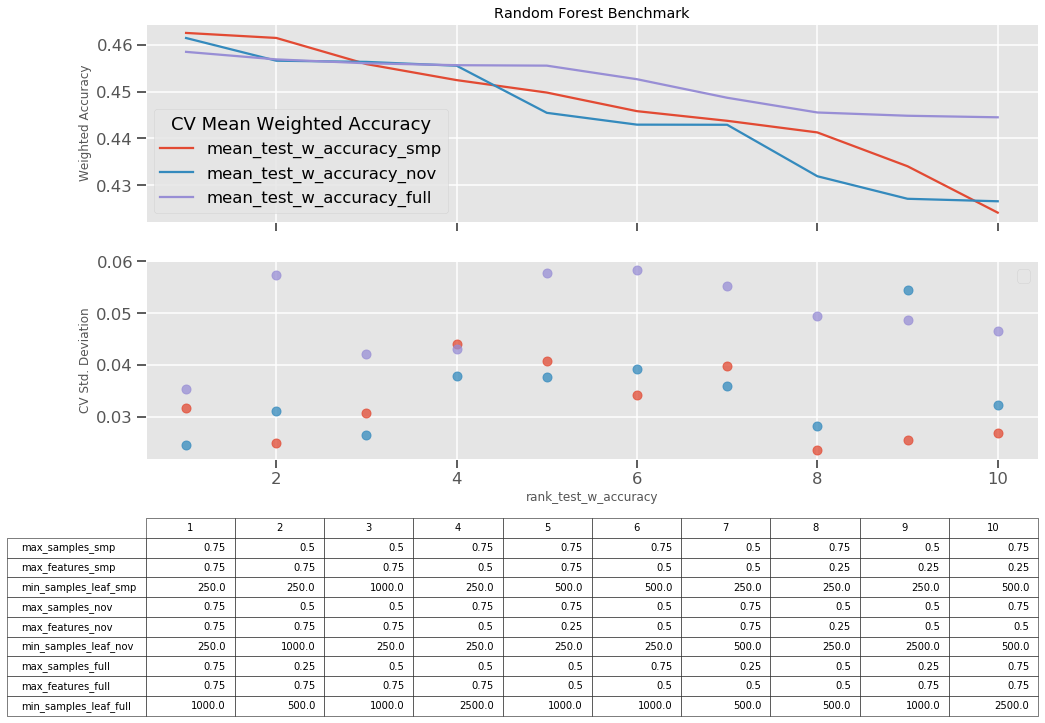

In [35]:
fig, axs = plt.subplots(2,1, sharex=True)

ax =  axs[0]
rf_sum_join_top_df.filter(regex='^mean_').plot(ax=ax, label=['sample', 'sample no weekday (nov)', 'full'])
ax.legend(title='CV Mean Weighted Accuracy')
ax.set_ylabel('Weighted Accuracy')
ax.set_title("Random Forest Benchmark")

ax =  axs[1]
ax = rf_sum_join_top_df.filter(regex='^std_').plot(ax=ax, style='o', alpha=0.75)
ax.legend("")
ax.set_ylabel('CV Std. Deviation')


rf_params_cols = [x for x in rf_sum_join_top_df.columns if x[:x.rfind("_")] in rf_params]
colors = [[ax.get_lines()[i].get_color()]*len(rf_params) for i in range(0,3)]

rf_benchmark_tb = plt.table(cellText=rf_sum_join_top_df[rf_params_cols].T.astype(str).values,
                      rowLabels=rf_params_cols,
                      colLabels=rf_sum_join_top_df.index,
                      loc='bottom',bbox=[0., -1.3, 1., 1.])#[left, bottom, width , height]

rf_benchmark_tb.auto_set_font_size(True)


plt.show()

## Experimental Ensemble

In [36]:
hparams_rf_nov = {'max_samples': 0.5,
            'max_features': 0.75,
            'min_samples_leaf': 500}

In [37]:
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED, **hparams_rf_nov)

In [38]:
rf_nov = mle_utils.NoOverlapVoterRegressor(base_estimator=rf, n_skip_samples=4)
rf_nov.fit(X_train_full[features_nov], y_train_full)

NoOverlapVoterRegressor(base_estimator=RandomForestRegressor(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             criterion='mse',
                                                             max_depth=None,
                                                             max_features=0.75,
                                                             max_leaf_nodes=None,
                                                             max_samples=0.5,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=500,
                                                             min_samples_split=2,
                                                             min_weight_fraction_leaf=0.0,
                      

# Write Reports

In [42]:
benchmark_path = os.path.join(io_utils.interim_path, f"benchmark_{MODEL_VERSION}", "")

rf_sum_df.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "rf_smp_summary.csv")
rf_full_sum_df.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "rf_full_summary.csv")
rf_nov_sum_df.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "rf_nov_summary.csv")

rf_sum_join_df.to_csv(benchmark_path + "rf_benchmark.csv")
rf_metrics_cvdet.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "rf_smp_cvdet.csv")
rf_full_metrics_cvdet.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "rf_full_cvdet.csv")
rf_nov_metrics_cvdet.set_index('rank_test_w_accuracy').to_csv(benchmark_path + "rf_nov_cvdet.csv")